資料作成用シート

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

In [3]:
###訓練データの読み込み
house_age = pd.read_csv('house_age.csv')
area_size = pd.read_csv('area_size.csv')
room_arrange = pd.read_csv('room_arrange.csv')
contract_span = pd.read_csv('contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('reg_rent.csv')
floor_scores = pd.read_csv('floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('stations.csv')
minits = pd.read_csv('minits.csv')
addresses = pd.read_csv('addresses.csv')
room_arrange = pd.read_csv('room_arrange.csv')

rent = pd.read_csv('rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('test_house_age.csv')
test_area_size = pd.read_csv('test_area_size.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_contract_span = pd.read_csv('test_contract_span.csv')
test_contract_span2 = pd.read_csv('test_contract_span2.csv')
test_reg_rent = pd.read_csv('test_reg_rent.csv')
test_floor_scores = pd.read_csv('test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('test_capital_floor_scores2.csv')
test_stations = pd.read_csv('test_stations.csv')
test_minits = pd.read_csv('test_minits.csv')
test_addresses = pd.read_csv('test_addresses.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')

元データを表示

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train.isnull().sum()

id           0
賃料           0
所在地          0
アクセス         0
間取り          0
築年数          0
方角        2749
面積           0
所在階          0
バス・トイレ     329
キッチン       621
放送・通信     3440
室内設備        82
駐車場       5287
周辺環境      9432
建物構造         0
契約期間      7120
dtype: int64

検証用データとテストデータで偏りがあるのかどうか確認

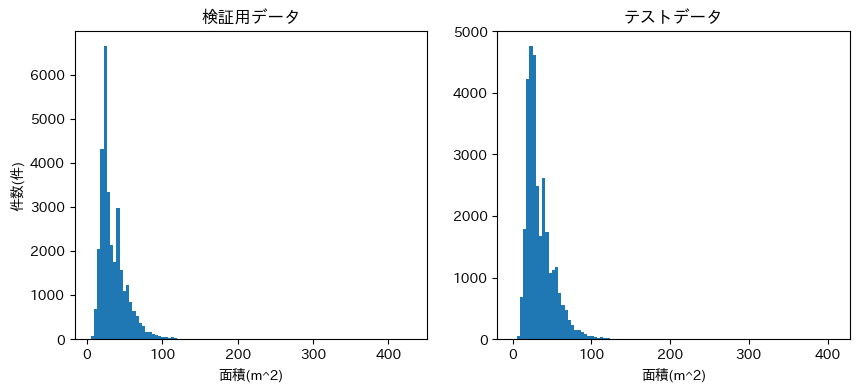

In [16]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.hist(area_size, bins=100)
ax.set_xlabel('面積(m^2)')
ax.set_ylabel('件数(件)')
ax.set_title('検証用データ')
ax2.hist(test_area_size, bins=100)
ax2.set_xlabel('面積(m^2)')
ax2.set_title('テストデータ')

plt.show()

外れ値・異常値の検討

In [22]:
df = pd.read_csv('train.csv')
house_age = df['築年数']

i = 0
for s in house_age:
    #"新築"という値が入力されている場合は0で埋める
    if (s == "新築"):
        house_age[i] = 0
        i += 1
        continue
    #"年"という文字より前の数値を抽出する
    target1 = '年'
    idx1 = s.find(target1)
    years = int( s[:idx1] )
    #"ヶ"と"年"の間にある数値を抽出する
    target2 = 'ヶ'
    idx2 = s.find(target2)
    months = int( s[idx1+1:idx2] )
    #house_ageの各行を、新築からの月齢を数値で置き換える。
    house_age[i] = 12*years + months
    # if house_age[i] > 1200:
    #     house_age[i] = nan
    i+=1

C:\Users\koshi\AppData\Local\Temp\ipykernel_11108\2497966210.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_age[i] = 12*years + months
C:\Users\koshi\AppData\Local\Temp\ipykernel_11108\2497966210.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_age[i] = 0


In [23]:
house_age.max()

12235

Text(0, 0.5, '築年数（ヶ月）')

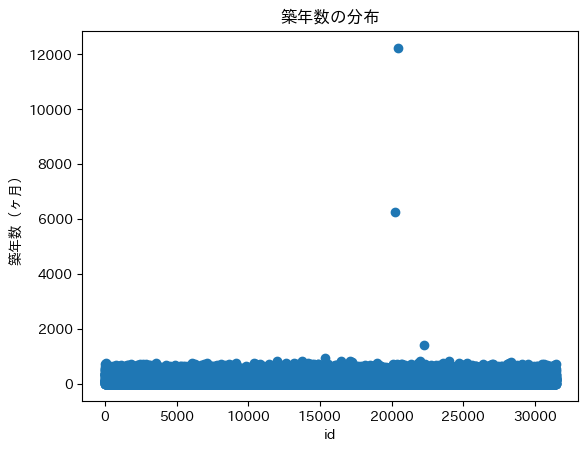

In [29]:
plt.scatter(df['id'],house_age)
plt.title('築年数の分布')
plt.xlabel('id')
plt.ylabel('築年数（ヶ月）')

アンサンブル結果の図を作成

In [4]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K","S"]]], axis=1)

#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# sX_train, sX_valid, sy_train, sy_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [9]:
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K','S']

cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]
    sX_tr, sX_val, sy_tr, sy_val = train_test_split(X_tr, y_tr, test_size=0.1, random_state=0)

    ####LisgtGBM###
    lgb_train = lgb.Dataset(sX_tr, sy_tr)
    lgb_eval = lgb.Dataset(sX_val, sy_val, reference=lgb_train)
    params_LGBM = {
        'objective':'regression',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 4.430375245218262e-06,
        'max_bin': 502,
        'num_leaves': 97
    }
    model_LGBM = lgb.train(
                        params_LGBM,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=3000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

    ###DART###
    lgb_train = lgb.Dataset(sX_tr, sy_tr)
    lgb_eval = lgb.Dataset(sX_val, sy_val, reference=lgb_train)
    params_DART = {
        'objective':'regression',
        'boosting_type':'dart',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 2.1600820741402023e-05,
        'max_bin': 556,
        'num_leaves': 126
    }

    model_DART = lgb.train(
                        params_DART,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=2000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

    ###GOSS###
    lgb_train = lgb.Dataset(sX_tr, sy_tr)
    lgb_eval = lgb.Dataset(sX_val, sy_val, reference=lgb_train)
    params_GOSS = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 4.669226029558975e-07,
        'max_bin': 584,
        'num_leaves': 85
    }

    model_GOSS = lgb.train(
                        params_GOSS,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

    ###XGBoost###
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        objective='reg:linear',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        learning_rate=0.05,
                        max_depth=7,
                        random_state=0,
                        reg_alfa=2.054762512591133e-06,
                        sub_sample=0.5530198332197337,
                        colsample_bytree=0.7642417009494488,
                        min_child_weight=0.14135935551752302
    )
    xgb_reg.fit(sX_tr, sy_tr, eval_set=[(sX_val, sy_val)], early_stopping_rounds=10)

_, X_valid, _, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# 個別のモデルの予測値たち。
valid_pred_LGBM = model_LGBM.predict(X_valid)
valid_pred_DART = model_DART.predict(X_valid)
valid_pred_GOSS = model_GOSS.predict(X_valid)
valid_pred_XGB = xgb_reg.predict(X_valid)

# ブレンドの特徴量になるものをまとめる。
stack_valid_pred = np.column_stack((valid_pred_LGBM,valid_pred_DART,valid_pred_GOSS,valid_pred_XGB))

# ブレンドの作成。
blend_model = RandomForestRegressor()

# ブレンドの特徴量として作ったデータと元データのy_validでブレンドを学習させる。
blend_model.fit(stack_valid_pred, y_valid)

# ここのモデルによるテストデータからの予測値
pred_LGBM = model_LGBM.predict(X_test)
pred_DART = model_DART.predict(X_test)
pred_GOSS = model_GOSS.predict(X_test)
pred_XGB = xgb_reg.predict(X_test)

pred_LGBM = pd.DataFrame(pred_LGBM)
pred_DART = pd.DataFrame(pred_DART)
pred_GOSS = pd.DataFrame(pred_GOSS)
pred_XGB = pd.DataFrame(pred_XGB)

#　ブレンドモデルのテストデータを作成
stack_test_pred = np.column_stack((pred_LGBM, pred_DART, pred_GOSS, pred_XGB))
print("ブレンドモデルに入れるテストデータ",stack_test_pred)

#ブレンドモデルによる最終の予測値
blend_pred = blend_model.predict(stack_test_pred)
blend_pred = pd.DataFrame(blend_pred)

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 22658, number of used features: 14
[LightGBM] [Info] Start training from score 118553.622032
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50328	valid_1's rmse: 47240
[20]	training's rmse: 35797.3	valid_1's rmse: 34001.6
[30]	training's rmse: 26774	valid_1's rmse: 26849.9
[40]	training's rmse: 21130.3	valid_1's rmse: 22299.8
[50]	training's rmse: 17778.9	valid_1's rmse: 20033
[60]	training's rmse: 15623.4	valid_1's rmse: 18753.8
[70]	training's rmse: 14230.2	valid_1's rmse: 18066.9
[80]	training's rmse: 13242.3	valid_1's rmse: 17749.3
[90]	training's rmse: 12509.4	valid_1's rmse: 17654.3
[100]	training's rmse: 11942.6	valid_1's rmse: 17593.9
[110]	training's rmse: 11468.6	valid_1's rmse: 17558
[12

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	training's rmse: 52746.9	valid_1's rmse: 49256.4
[20]	training's rmse: 38964	valid_1's rmse: 36825.4
[30]	training's rmse: 30786.7	valid_1's rmse: 29813.9
[40]	training's rmse: 27345.1	valid_1's rmse: 27007.5
[50]	training's rmse: 30944.1	valid_1's rmse: 30339
[60]	training's rmse: 35246	valid_1's rmse: 35002.7
[70]	training's rmse: 37171.2	valid_1's rmse: 37152.8
[80]	training's rmse: 32038.9	valid_1's rmse: 32412.5
[90]	training's rmse: 32041.6	valid_1's rmse: 32213.3
[100]	training's rmse: 34063.2	valid_1's rmse: 34459.4
[110]	training's rmse: 40972.2	valid_1's rmse: 41011.9
[120]	training's rmse: 32560.7	valid_1's rmse: 33338.1
[130]	training's rmse: 29363.4	valid_1's rmse: 30404.5
[140]	training's rmse: 32195.2	valid_1's rmse: 33211.1
[150]	training's rmse: 30711.2	valid_1's rmse: 31876.7
[160]	training's rmse: 35464.2	valid_1's rmse: 36273.8
[170]	training's rmse: 28536.1	valid_1's rmse: 30190.1
[180]	training's rmse: 27278.5	valid_1's rmse: 29240
[190]	training's rmse: 2324

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:87083.85510
[10]	validation_0-rmse:83483.85048
[11]	validation_0-rmse:79951.89141
[12]	validation_0-rmse:76512.12826
[13]	validation_0-rmse:73421.76681
[14]	validation_0-rmse:70634.86397
[15]	validation_0-rmse:67762.10027
[16]	validation_0-rmse:64918.17407
[17]	validation_0-rmse:62396.94964
[18]	validation_0-rmse:59909.83617
[19]	validation_0-rmse:57787.68179
[20]	validation_0-rmse:55588.96082
[21]	validation_0-rmse:53763.02769
[22]	validation_0-rmse:52051.75244
[23]	validation_0-rmse:50265.05154
[24]	validation_0-rmse:48600.89504
[25]	validation_0-rmse:47192.52138
[26]	validation_0-rmse:45687.37045
[27]	validation_0-rmse:44394.91979
[28]	validation_0-rmse:43265.35583
[29]	validation_0-rmse:42055.87401
[30]	validation_0-rmse:40889.43144
[31]	validation_0-rmse:39869.76373
[32]	validation_0-rmse:38808.90366
[33]	validation_0-rmse:37961.31456
[34]	validation_0-rmse:37066.66907
[35]	validation_0-rmse:36246.65014
[36]	validation_0-rmse:35423.61654
[37]	validation_0-rms

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 22658, number of used features: 14
[LightGBM] [Info] Start training from score 118599.114661
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51256.1	valid_1's rmse: 47463.3
[20]	training's rmse: 37104.2	valid_1's rmse: 33442.5
[30]	training's rmse: 29054.1	valid_1's rmse: 26138.7
[40]	training's rmse: 23897.3	valid_1's rmse: 21454.4
[50]	training's rmse: 20945.9	valid_1's rmse: 18636.7
[60]	training's rmse: 19148.1	valid_1's rmse: 17230.9
[70]	training's rmse: 18015.1	valid_1's rmse: 16425.7
[80]	training's rmse: 17122.7	valid_1's rmse: 15922.4
[90]	training's rmse: 16452.7	valid_1's rmse: 15643.6
[100]	training's rmse: 15936.3	valid_1's rmse: 15493.7
[110]	training's rmse: 15502.6	valid_1's rmse: 1

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	training's rmse: 53337.6	valid_1's rmse: 51063.1
[20]	training's rmse: 39900.6	valid_1's rmse: 38101.9
[30]	training's rmse: 32584.7	valid_1's rmse: 30676.4
[40]	training's rmse: 29563.3	valid_1's rmse: 28006.9
[50]	training's rmse: 32847.7	valid_1's rmse: 31394.4
[60]	training's rmse: 36919.4	valid_1's rmse: 35818.7
[70]	training's rmse: 38783	valid_1's rmse: 37987.5
[80]	training's rmse: 33984.5	valid_1's rmse: 33274.7
[90]	training's rmse: 33886.2	valid_1's rmse: 33131.2
[100]	training's rmse: 35810.4	valid_1's rmse: 35182.9
[110]	training's rmse: 42369.7	valid_1's rmse: 41805
[120]	training's rmse: 34545.6	valid_1's rmse: 33973.6
[130]	training's rmse: 31528.2	valid_1's rmse: 31133.3
[140]	training's rmse: 34056	valid_1's rmse: 33531
[150]	training's rmse: 32609.1	valid_1's rmse: 32168.9
[160]	training's rmse: 37135.8	valid_1's rmse: 36729
[170]	training's rmse: 30592.9	valid_1's rmse: 30014.4
[180]	training's rmse: 29410.4	valid_1's rmse: 28823.5
[190]	training's rmse: 25704.

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:91239.47976
[9]	validation_0-rmse:87266.44084
[10]	validation_0-rmse:83841.92912
[11]	validation_0-rmse:80285.91605
[12]	validation_0-rmse:76946.06193
[13]	validation_0-rmse:73800.15171
[14]	validation_0-rmse:71106.57819
[15]	validation_0-rmse:68300.88753
[16]	validation_0-rmse:65584.58446
[17]	validation_0-rmse:62929.07155
[18]	validation_0-rmse:60576.53891
[19]	validation_0-rmse:58605.13880
[20]	validation_0-rmse:56585.87243
[21]	validation_0-rmse:54820.11278
[22]	validation_0-rmse:53089.74342
[23]	validation_0-rmse:51120.48444
[24]	validation_0-rmse:49379.90210
[25]	validation_0-rmse:48040.96761
[26]	validation_0-rmse:46461.19962
[27]	validation_0-rmse:45087.82108
[28]	validation_0-rmse:43961.16700
[29]	validation_0-rmse:42713.31658
[30]	validation_0-rmse:41547.78367
[31]	validation_0-rmse:40334.05115
[32]	validation_0-rmse:39247.40052
[33]	validation_0-rmse:38342.97006
[34]	validation_0-rmse:37471.72720
[35]	validation_0-rmse:36692.91636
[36]	validation_0-rmse

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Number of data points in the train set: 22658, number of used features: 14
[LightGBM] [Info] Start training from score 118177.504678
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51578.1	valid_1's rmse: 43064.2
[20]	training's rmse: 37847.3	valid_1's rmse: 31334
[30]	training's rmse: 29156	valid_1's rmse: 24609
[40]	training's rmse: 23756.9	valid_1's rmse: 20694.3
[50]	training's rmse: 20655.1	valid_1's rmse: 18471.8
[60]	training's rmse: 18751.3	valid_1's rmse: 17069.7
[70]	training's rmse: 17505.4	valid_1's rmse: 16282.4
[80]	training's rmse: 16664.2	valid_1's rmse: 15656.9
[90]	training's rmse: 16074.9	valid_1's rmse: 15262.3
[100]	training's rmse: 15565.8	valid_1's rmse: 15013.1
[110]	training's rmse: 15151.6	valid_1's rmse: 14897.9

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[20]	training's rmse: 41080.1	valid_1's rmse: 33411.7
[30]	training's rmse: 33425.6	valid_1's rmse: 27561.9
[40]	training's rmse: 30214.4	valid_1's rmse: 25207.9
[50]	training's rmse: 33262.7	valid_1's rmse: 28369.1
[60]	training's rmse: 37078.6	valid_1's rmse: 33083.9
[70]	training's rmse: 38866.4	valid_1's rmse: 35224.1
[80]	training's rmse: 34010.5	valid_1's rmse: 30599.4
[90]	training's rmse: 34003.4	valid_1's rmse: 30167.8
[100]	training's rmse: 35911.5	valid_1's rmse: 32410.2
[110]	training's rmse: 42497.5	valid_1's rmse: 38847.2
[120]	training's rmse: 34448.4	valid_1's rmse: 31274.7
[130]	training's rmse: 31432.9	valid_1's rmse: 28411.5
[140]	training's rmse: 34003.2	valid_1's rmse: 31319.3
[150]	training's rmse: 32573.4	valid_1's rmse: 29857.5
[160]	training's rmse: 37105.8	valid_1's rmse: 34256.5
[170]	training's rmse: 30448.4	valid_1's rmse: 28305.1
[180]	training's rmse: 29298.6	valid_1's rmse: 27277
[190]	training's rmse: 25539.4	valid_1's rmse: 23860.8
[200]	training's rms

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:86715.01085
[9]	validation_0-rmse:82803.35863
[10]	validation_0-rmse:79206.50212
[11]	validation_0-rmse:75744.93120
[12]	validation_0-rmse:72460.02168
[13]	validation_0-rmse:69405.77060
[14]	validation_0-rmse:66607.18905
[15]	validation_0-rmse:63921.91144
[16]	validation_0-rmse:61297.34328
[17]	validation_0-rmse:58872.89793
[18]	validation_0-rmse:56596.21124
[19]	validation_0-rmse:54445.97150
[20]	validation_0-rmse:52442.51856
[21]	validation_0-rmse:50587.17902
[22]	validation_0-rmse:48871.28175
[23]	validation_0-rmse:47047.49595
[24]	validation_0-rmse:45374.87573
[25]	validation_0-rmse:43904.89013
[26]	validation_0-rmse:42519.59315
[27]	validation_0-rmse:41228.82352
[28]	validation_0-rmse:40094.58548
[29]	validation_0-rmse:38963.72553
[30]	validation_0-rmse:37919.43940
[31]	validation_0-rmse:36942.77769
[32]	validation_0-rmse:35984.37863
[33]	validation_0-rmse:35075.13834
[34]	validation_0-rmse:34259.72295
[35]	validation_0-rmse:33544.52986
[36]	validation_0-rmse

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2341
[LightGBM] [Info] Number of data points in the train set: 22658, number of used features: 14
[LightGBM] [Info] Start training from score 118475.459352
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51822.4	valid_1's rmse: 45317.5
[20]	training's rmse: 37739.1	valid_1's rmse: 32680.2
[30]	training's rmse: 28952.4	valid_1's rmse: 25342.4
[40]	training's rmse: 23673.7	valid_1's rmse: 20645.4
[50]	training's rmse: 20642.4	valid_1's rmse: 17865.7
[60]	training's rmse: 18786.4	valid_1's rmse: 16413
[70]	training's rmse: 17562.3	valid_1's rmse: 15387.6
[80]	training's rmse: 16674.8	valid_1's rmse: 14777.4
[90]	training's rmse: 15978.6	valid_1's rmse: 14436.5
[100]	training's rmse: 15468.8	valid_1's 

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[20]	training's rmse: 40809.3	valid_1's rmse: 35314.7
[30]	training's rmse: 33128.9	valid_1's rmse: 28587
[40]	training's rmse: 29944.4	valid_1's rmse: 25897.7
[50]	training's rmse: 33102.8	valid_1's rmse: 29173
[60]	training's rmse: 37061.4	valid_1's rmse: 33686.7
[70]	training's rmse: 38938.3	valid_1's rmse: 35769
[80]	training's rmse: 34097.7	valid_1's rmse: 30903.1
[90]	training's rmse: 34066.9	valid_1's rmse: 30633.3
[100]	training's rmse: 35931.8	valid_1's rmse: 32841.2
[110]	training's rmse: 42519.5	valid_1's rmse: 39420.9
[120]	training's rmse: 34402.2	valid_1's rmse: 31440.7
[130]	training's rmse: 31384	valid_1's rmse: 28395.6
[140]	training's rmse: 33991	valid_1's rmse: 31269.2
[150]	training's rmse: 32638.8	valid_1's rmse: 29825.3
[160]	training's rmse: 37197	valid_1's rmse: 34377.5
[170]	training's rmse: 30423.4	valid_1's rmse: 27999
[180]	training's rmse: 29315.9	valid_1's rmse: 26988
[190]	training's rmse: 25537.6	valid_1's rmse: 23337.6
[200]	training's rmse: 24580.7	val

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:81724.35058
[11]	validation_0-rmse:78175.06668
[12]	validation_0-rmse:74823.81659
[13]	validation_0-rmse:71702.35036
[14]	validation_0-rmse:68925.20186
[15]	validation_0-rmse:66163.91524
[16]	validation_0-rmse:63475.60362
[17]	validation_0-rmse:61040.42592
[18]	validation_0-rmse:58683.15762
[19]	validation_0-rmse:56568.96723
[20]	validation_0-rmse:54456.83130
[21]	validation_0-rmse:52600.54361
[22]	validation_0-rmse:50854.39073
[23]	validation_0-rmse:49054.82953
[24]	validation_0-rmse:47338.46534
[25]	validation_0-rmse:45961.27359
[26]	validation_0-rmse:44461.37281
[27]	validation_0-rmse:43032.87123
[28]	validation_0-rmse:41893.51875
[29]	validation_0-rmse:40676.95956
[30]	validation_0-rmse:39511.13328
[31]	validation_0-rmse:38434.40442
[32]	validation_0-rmse:37387.93575
[33]	validation_0-rmse:36494.65863
[34]	validation_0-rmse:35627.98651
[35]	validation_0-rmse:34824.34151
[36]	validation_0-rmse:34015.51469
[37]	validation_0-rmse:33239.63346
[38]	validation_0-rm

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 22658, number of used features: 14
[LightGBM] [Info] Start training from score 118196.819490
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50490.2	valid_1's rmse: 52098.5
[20]	training's rmse: 37192.7	valid_1's rmse: 39606.9
[30]	training's rmse: 29364.6	valid_1's rmse: 32248.6
[40]	training's rmse: 23967.1	valid_1's rmse: 26188.4
[50]	training's rmse: 20803.9	valid_1's rmse: 22571.8
[60]	training's rmse: 18886.2	valid_1's rmse: 20134.9
[70]	training's rmse: 17609.1	valid_1's rmse: 18615.2
[80]	training's rmse: 16771.1	valid_1's rmse: 17701.1
[90]	training's rmse: 16118.3	valid_1's rmse: 17102.9
[100]	training's rmse: 15640	valid_1's rmse: 16718.5
[110]	training's rmse: 15231	valid_1's rmse: 16434

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[20]	training's rmse: 40271.6	valid_1's rmse: 41758.1
[30]	training's rmse: 33011.7	valid_1's rmse: 34926.2
[40]	training's rmse: 29991.5	valid_1's rmse: 32023.6
[50]	training's rmse: 33193.8	valid_1's rmse: 35385.8
[60]	training's rmse: 37205.4	valid_1's rmse: 39209.9
[70]	training's rmse: 38999.4	valid_1's rmse: 40772.2
[80]	training's rmse: 34237.1	valid_1's rmse: 36065.7
[90]	training's rmse: 34124.9	valid_1's rmse: 36112.3
[100]	training's rmse: 36063.5	valid_1's rmse: 37979.7
[110]	training's rmse: 42540.8	valid_1's rmse: 44289.2
[120]	training's rmse: 34733.8	valid_1's rmse: 36752.3
[130]	training's rmse: 31795.6	valid_1's rmse: 33804.1
[140]	training's rmse: 34269.2	valid_1's rmse: 36070.5
[150]	training's rmse: 32893.5	valid_1's rmse: 34735
[160]	training's rmse: 37350.3	valid_1's rmse: 39060
[170]	training's rmse: 30673.2	valid_1's rmse: 32580.9
[180]	training's rmse: 29480.5	valid_1's rmse: 31542
[190]	training's rmse: 25749.7	valid_1's rmse: 27876.1
[200]	training's rmse: 2

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:91402.24141
[10]	validation_0-rmse:88106.89925
[11]	validation_0-rmse:84594.66868
[12]	validation_0-rmse:81223.79657
[13]	validation_0-rmse:78137.34932
[14]	validation_0-rmse:75516.62367
[15]	validation_0-rmse:72715.31137
[16]	validation_0-rmse:70025.15785
[17]	validation_0-rmse:67571.26643
[18]	validation_0-rmse:65252.18829
[19]	validation_0-rmse:63265.77794
[20]	validation_0-rmse:61187.25903
[21]	validation_0-rmse:59477.00895
[22]	validation_0-rmse:57894.44502
[23]	validation_0-rmse:56060.55578
[24]	validation_0-rmse:54339.04623
[25]	validation_0-rmse:52986.27348
[26]	validation_0-rmse:51496.78573
[27]	validation_0-rmse:50127.53013
[28]	validation_0-rmse:49080.19461
[29]	validation_0-rmse:47832.72538
[30]	validation_0-rmse:46697.85823
[31]	validation_0-rmse:45619.74596
[32]	validation_0-rmse:44619.27000
[33]	validation_0-rmse:43638.25157
[34]	validation_0-rmse:42727.41122
[35]	validation_0-rmse:41819.70977
[36]	validation_0-rmse:40974.89582
[37]	validation_0-rms

C:\Users\koshi\AppData\Local\Temp\ipykernel_11588\153842625.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  blend_model.fit(stack_valid_pred, y_valid)


ブレンドモデルに入れるテストデータ [[127882.25435426 133158.18829942 132353.12794536 113297.6484375 ]
 [122453.13455465 121367.77672922 120437.67734868 120189.9765625 ]
 [ 74218.85542142  76234.94058219  81180.24016138  80923.8828125 ]
 ...
 [175875.82795193 174197.99255845 178741.08017404 177196.625     ]
 [222271.86376039 244865.6002802  246056.49195444 276510.0625    ]
 [ 79008.01481931  80784.51268135  77402.02055357  80833.3046875 ]]


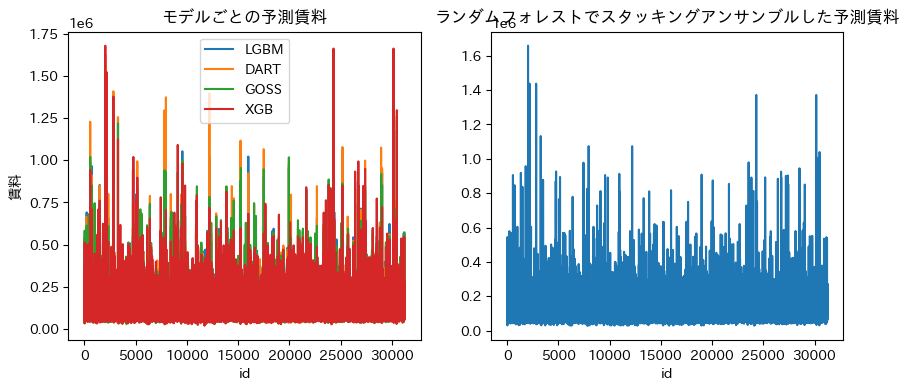

In [10]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(range(len(blend_pred)), pred_LGBM, label='LGBM')
ax.plot(range(len(blend_pred)), pred_DART, label='DART')
ax.plot(range(len(blend_pred)), pred_GOSS, label='GOSS')
ax.plot(range(len(blend_pred)), pred_XGB, label='XGB')
ax.set_xlabel("id")
ax.set_ylabel('賃料')
ax.set_title('モデルごとの予測賃料')

ax2.plot(range(len(blend_pred)), blend_pred)
ax2.set_xlabel('id')
ax2.set_title('ランダムフォレストでスタッキングアンサンブルした予測賃料')

ax.legend(loc='best')
plt.show()